Generative Adversarial Networks in Keras

First let's import all the necessary libraries
In this case Keras is running in a Tensorflow backend

In [83]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
import random
import pandas as pd
from __future__ import print_function

Now let's import MNIST data

In [84]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In this step, each digit type is adjusted to 'float32'

In [85]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

The following step selects a small sample from MNIST so that you can do the computation even without a GPU
After that, we add noise to data, using a random normal distribution with mean equal to zero and standard deviation equal to 1

In [86]:
n=60

x_train=x_train[0:n]
x_test=x_test[n:n+n]

noise_factor = 0.1
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 


Reshape inputs for the Neural Network that will be composed of real data and data with noise addded

In [87]:
def norm(x):
    return(x-np.min(x))/(np.max(x)-np.min(x))

x_train_noisy = norm(x_train_noisy)
x_test_noisy = norm(x_test_noisy)

x_train_noisy=np.concatenate([x_train_noisy,x_train_noisy])
x_test_noisy=np.concatenate([x_test_noisy,x_test_noisy])
x_train=norm(np.concatenate([x_train,x_train]))

np.random.seed(200)
sel=random.sample(range(0,x_train.shape[0]), n)
x_train_noisy=x_train_noisy[sel]
x_test_noisy=x_test_noisy[sel]
x_train=x_train[sel]


We select a random sample from real data + noisy data and get one-hot encodes for y_train

In [88]:
y_train=y_train[0:n]
y_train=np.concatenate([y_train,y_train])[sel]
y_train=np.array(pd.get_dummies(y_train)).astype(np.float32)
y_test=y_test[0:n]
y_test0=np.concatenate([y_test,y_test])[sel]
y_test=np.array(pd.get_dummies(y_test0))

x_train=np.array(x_train).astype(np.float64)
x_train_noisy=x_train_noisy.astype(np.float64)


We set the hyperparameters

In [89]:
num_steps = 10
batch_size = n
show_steps=50
learning_rate1=0.0001
image_dim = 784 
gen_hidden_dim = 80
disc_hidden_dim = 80
noise_dim = 10 

Now we develop the Generative part of the GAN using Keras and compile the model

In [90]:
def mean(x):
    mm,_=tf.nn.moments(x,axes=[0])
    return mm

def var(x):
    _,var=tf.nn.moments(x,axes=[0])
    return var

tf.reset_default_graph() 
def generator(x, reuse=False):
    with tf.variable_scope('Generator', reuse=reuse):
        x = tf.layers.dense(x, units=6 * 6 * 64)
        x = tf.nn.relu(x)
        x = tf.reshape(x, shape=[-1, 6, 6, 64])
        x = tf.layers.conv2d_transpose(x, 32, 4, strides=2)
        x = tf.nn.batch_normalization(x,mean=mean(x), variance=var(x),offset=None,scale=None,variance_epsilon=1e-3)
        x = tf.layers.conv2d_transpose(x, 1, 2, strides=2)
        x = tf.nn.relu(x)
        x = tf.reshape(x, [n,784])
        return x


Next, we create the Discriminator part of the GAN, using model.add instead of x=layer(x) to diversify our knowledge

In [91]:
def discriminator(x, reuse=False):
    with tf.variable_scope('Discriminator', reuse=reuse):
        x = tf.reshape(x, [n,28,28,1])
        x = tf.layers.conv2d(x, 32, 5)
        x = tf.nn.relu(x)
        x = tf.layers.average_pooling2d(x, 2, 2,padding='same')
        x = tf.layers.conv2d(x, 64, 5,padding='same')
        x = tf.nn.relu(x)
        x = tf.layers.average_pooling2d(x, 8, 8)
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, 784)
        x = tf.nn.sigmoid(x)
    return x


In the following cell, we'll create a function that will allow us to freeze the training of the Generator (OR NOT) so that we can try different update strategies with Discriminator and Generator

In [92]:
noise_input = tf.placeholder(tf.float32, shape=[None, 784])
real_image_input = tf.placeholder(tf.float32, shape=[None, 784])

with tf.name_scope('GenModel'):
    gen_sample = generator(noise_input)


disc_real = discriminator(real_image_input)


disc_fake = discriminator(gen_sample, reuse=True)
disc_concat = tf.concat([disc_real, disc_fake], axis=0)

with tf.name_scope('DiscModel'):
    stacked_gan = discriminator(gen_sample, reuse=True)

disc_target = tf.placeholder(tf.float32, shape=[None,784])
gen_target = tf.placeholder(tf.float32, shape=[None,784])



We compile the GAN

In [93]:
with tf.name_scope('GenLoss'):
    gen_loss = tf.reduce_mean(tf.losses.mean_squared_error(
    real_image_input,gen_sample))

'''ate aqui ok'''


with tf.name_scope('DiscLoss'):
    disc_loss = tf.reduce_mean(tf.losses.mean_squared_error(
    real_image_input,stacked_gan))



Now we will update Discriminator and Generator asynchronously in the proportion 1:1

In [94]:
tf.summary.scalar("Generator_Loss", gen_loss)
tf.summary.scalar("Discriminator_Loss", disc_loss)
x_image = tf.summary.image('input', tf.reshape(stacked_gan, [-1, 28, 28, 1]), 20)

logs_path = 'C:/Users/razim/Anaconda3/envs/tensorflow/Scripts/plot_1'

summary = tf.summary.merge_all()


optimizer_gen = tf.train.AdamOptimizer(learning_rate=learning_rate1)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=learning_rate1)

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator')
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator')

with tf.name_scope('SGDdisc'):
    train_disc = optimizer_disc.minimize(disc_loss)


with tf.name_scope('SGDgen'):
    train_gen = optimizer_gen.minimize(gen_loss)



init = tf.global_variables_initializer()

Now we reset all variables that were reshaped and one-hot encoded to calculate accuracy in training and test set

In [95]:
def next_batch(num, data, labels):
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]
    return np.asarray(data_shuffle).astype(np.float32), np.asarray(labels_shuffle).astype(np.float32)


summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())



In [96]:
with tf.Session() as sess:
    sess.run(init)
    for i in range(1, num_steps+1):
        batch_x, batch_y=next_batch(batch_size, x_train
                                    , x_train_noisy)        
        feed_dict = {real_image_input: batch_x, noise_input: batch_y,
                     disc_target: batch_x, gen_target: batch_y}
        _, _, gl, dl,summary2 = sess.run([train_gen, train_disc, gen_loss, disc_loss,summary],
                                feed_dict=feed_dict)
        g = sess.run([stacked_gan], feed_dict={noise_input: batch_y})
        h = sess.run([gen_sample], feed_dict={noise_input: batch_y})
        summary_writer.add_summary(summary2, i)
        if i % show_steps == 0 or i == 1:
            print('Epoch %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))


Epoch 1: Generator Loss: 0.174185, Discriminator Loss: 0.231508


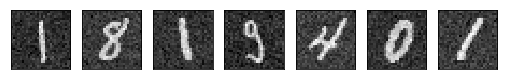

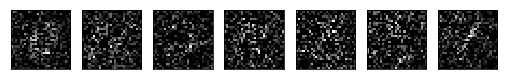

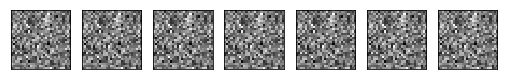

'RUN\ntensorboard --logdir=C:/Users/razim/Anaconda3/envs/tensorflow/Scripts/plot_1'

In [97]:
plt.figure(figsize=(10, 10))
for i in range(11,18):
    ax = plt.subplot(1, 8, i-10)
    plt.imshow(x_train_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.figure(figsize=(10, 10))
for i in range(11,18):
    ax = plt.subplot(1, 8, i-10)
    plt.imshow(np.array(h).reshape(60,28, 28)[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
plt.figure(figsize=(10, 10))
for i in range(11,18):
    ax = plt.subplot(1, 8, i-10)
    plt.imshow(np.array(g).reshape(60,28, 28)[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

'''RUN
tensorboard --logdir=C:/Users/razim/Anaconda3/envs/tensorflow/Scripts/plot_1'''
